In [1]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
import grasp2alm as g2a
from scipy.interpolate import RegularGridInterpolator

In [2]:
with open('spherical_grid.grd', 'r') as file:
    a = file.readline()
    while '++++' not in a:
        a = file.readline()
    ktype = file.readline()
    nset, icomp, ncomp, igrid = [int(i) for i in file.readline().split()]
    ix, iy = [int(i) for i in file.readline().split()]
    xs, ys, xe, ye = [float(i) for i in file.readline().split()]
    nx, ny, klimit = [int(i) for i in file.readline().split()]
    grid = file.read().split()

In [3]:
grid_np_raw = np.array(grid, dtype=float)
grid_np = grid_np_raw.reshape(nx, ny, 4).transpose(1,0,2)

In [4]:
E_co = grid_np[:,:,0] + grid_np[:,:,1] * 1j
E_cx = grid_np[:,:,2] + grid_np[:,:,3] * 1j

In [5]:
u = np.linspace(xs, xe, nx)
v = np.linspace(ys, ye, ny)

uv_x, uv_y = np.meshgrid(u, v)
phi = np.arctan2(uv_y, uv_x)
theta = np.arcsin(np.hypot(uv_x,uv_y))
# Shift phi to [0, 2pi]
# phi = phi -1*(np.sign(np.arctan2(uv_y,uv_x))+1)*np.pi
phi = -phi.T + np.pi

# Usefull in plots
extent = [u.min(),u.max(),v.min(),v.max()]

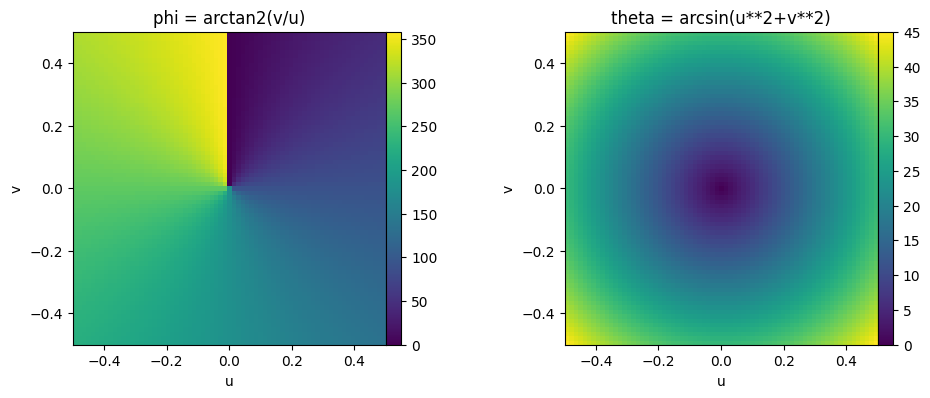

In [6]:
fig, axs = plt.subplots(1,2, figsize = (10,4))
phi_grid_plot = axs[0].imshow(np.rad2deg(phi), extent = extent)
theta_grid_plot = axs[1].imshow(np.rad2deg(theta), extent = extent)
fig.colorbar(theta_grid_plot, ax=axs[1], pad=0)
fig.colorbar(phi_grid_plot, ax=axs[0], pad=0)
axs[0].set_title('phi = arctan2(v/u)')
axs[0].set_xlabel('u')
axs[0].set_ylabel('v')
axs[1].set_title('theta = arcsin(u**2+v**2)')
axs[1].set_xlabel('u')
axs[1].set_ylabel('v')
fig.tight_layout()

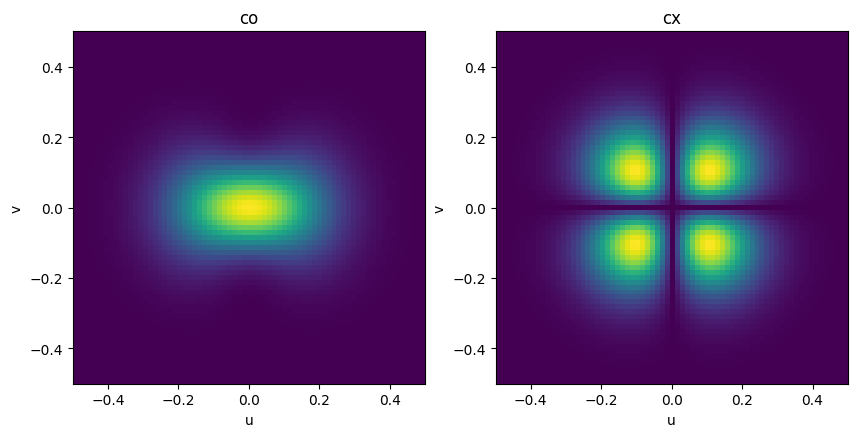

In [7]:
_, axs = plt.subplots(1,2, figsize = (10,10))
axs[0].imshow(np.abs(E_co), extent=extent)
axs[0].set_title('co')
axs[0].set_xlabel('u')
axs[0].set_ylabel('v')
axs[1].imshow(np.abs(E_cx), extent=extent)
axs[1].set_title('cx')
axs[1].set_xlabel('u')
axs[1].set_ylabel('v')
plt.show()

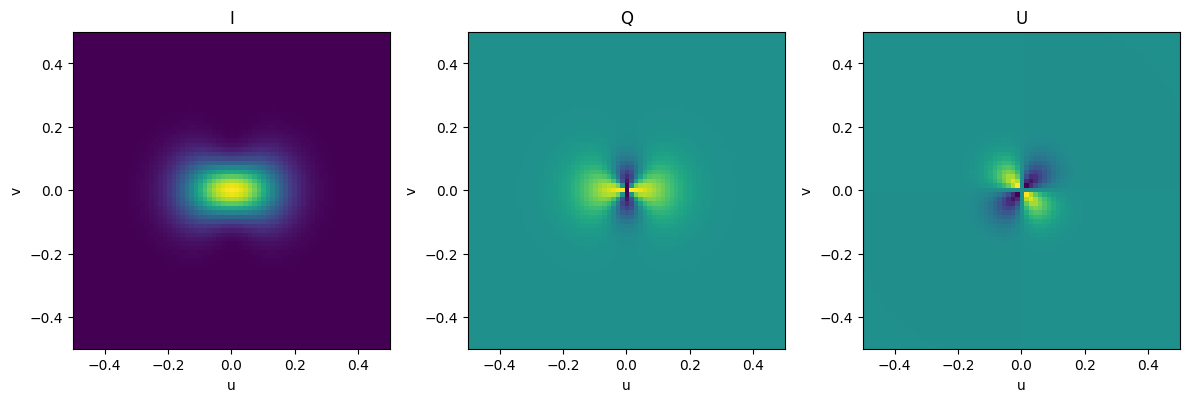

In [8]:
I = np.abs(E_co)**2 + np.abs(E_cx)**2
Q = -(np.abs(E_co)**2 - np.abs(E_cx)**2)*np.cos(2*phi)+2*np.real(E_co*np.conj(E_cx))*np.sin(2*phi)
U = -(np.abs(E_co)**2 - np.abs(E_cx)**2)*np.sin(2*phi)-2*np.real(E_co*np.conj(E_cx))*np.cos(2*phi)

fig, axs = plt.subplots(1,3, figsize = (12,10))
axs[0].imshow(I, extent=extent)
axs[1].imshow(Q, extent=extent)
axs[2].imshow(U, extent=extent)
for index, title in enumerate(['I','Q','U']):
    axs[index].set_title(title)
    axs[index].set_title(title)
    axs[index].set_title(title)
    axs[index].set_xlabel('u')
    axs[index].set_ylabel('v')
fig.tight_layout()
plt.show()

In [9]:
#pixel = np.zeros((nx,ny))
#nside = 128
#m = np.full(hp.nside2npix(nside), hp.UNSEEN)
#for ix in range(nx):
#    for iy in range(ny):
#        pixel[ix,iy] = hp.ang2pix(nside, theta[ix,iy], phi[ix,iy])

#mask = [int(i) for  i in pixel.flatten()]

#m[mask] = I.flatten()

In [10]:
#hp.gnomview(m, rot = [0,90])

In [11]:
nside = 256
npix = hp.nside2npix(nside)
new_theta, new_phi = hp.pix2ang(nside, np.arange(npix))

In [12]:
interpolator_I = RegularGridInterpolator(
    (u,v),
    I, 
    method='linear', 
)

interpolator_Q = RegularGridInterpolator(
    (u,v),
    Q, 
    method='linear', 
)

interpolator_U = RegularGridInterpolator(
    (u,v),
    U, 
    method='linear', 
)

In [13]:
u_all = np.sin(new_theta)*np.cos(new_phi)
v_all = np.sin(new_theta)*np.sin(new_phi)
new_map_I = np.full(npix, hp.UNSEEN)
new_map_Q = np.full(npix, hp.UNSEEN)
new_map_U = np.full(npix, hp.UNSEEN)
for i in range(len(new_map_I)):
    if abs(new_theta[i])<=theta.max() and abs(v_all[i])<=v.max() and abs(u_all[i])<=u.max():
        new_map_I[i] = interpolator_I([u_all[i], v_all[i]])
        new_map_Q[i] = interpolator_Q([u_all[i], v_all[i]])
        new_map_U[i] = interpolator_U([u_all[i], v_all[i]])

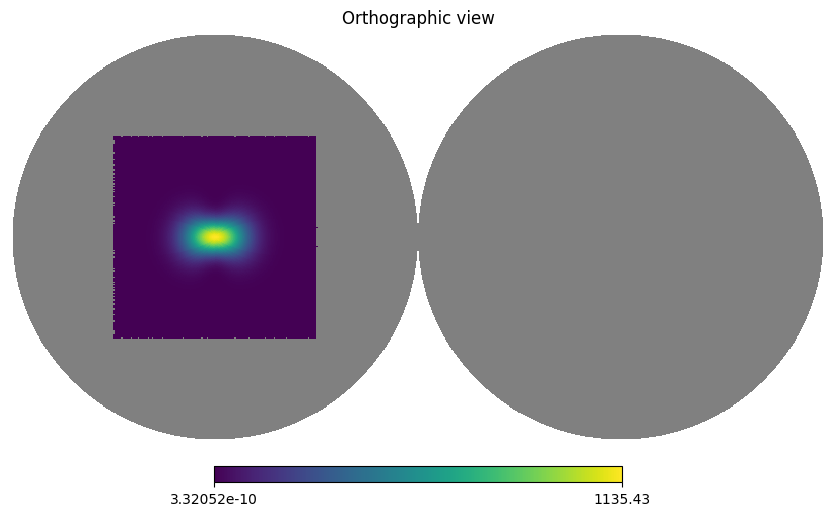

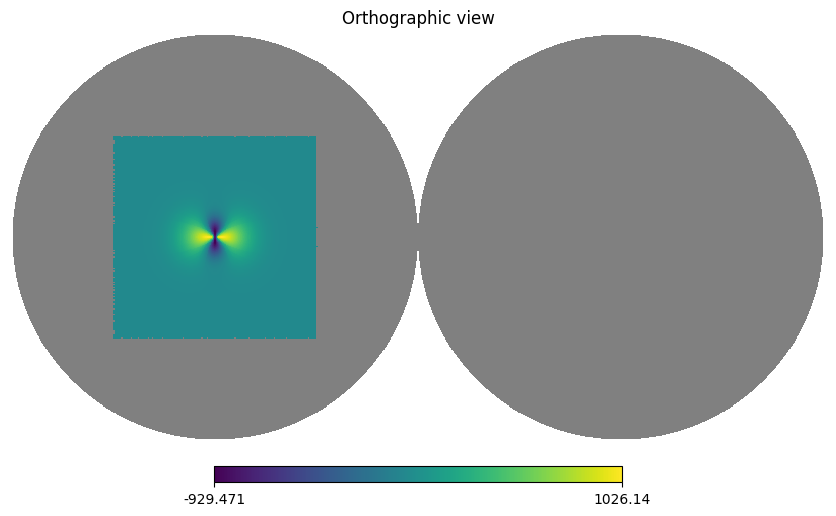

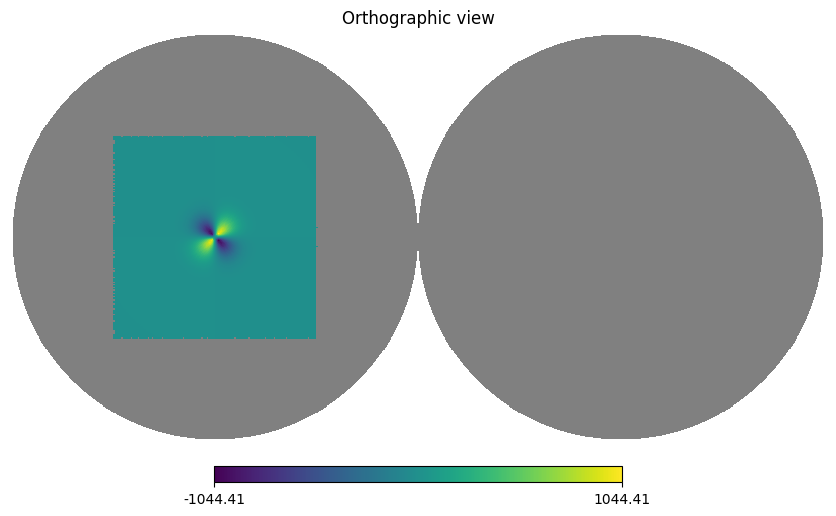

In [14]:
hp.orthview(new_map_I, rot=(0,90))
hp.orthview(new_map_Q, rot=(0,90))
hp.orthview(new_map_U, rot=(0,90))

# Comparison with .cut open with grasp2alm

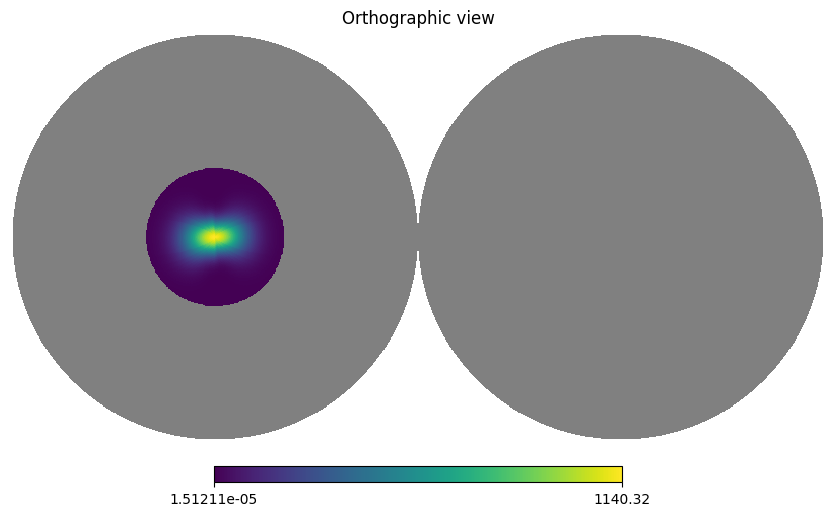

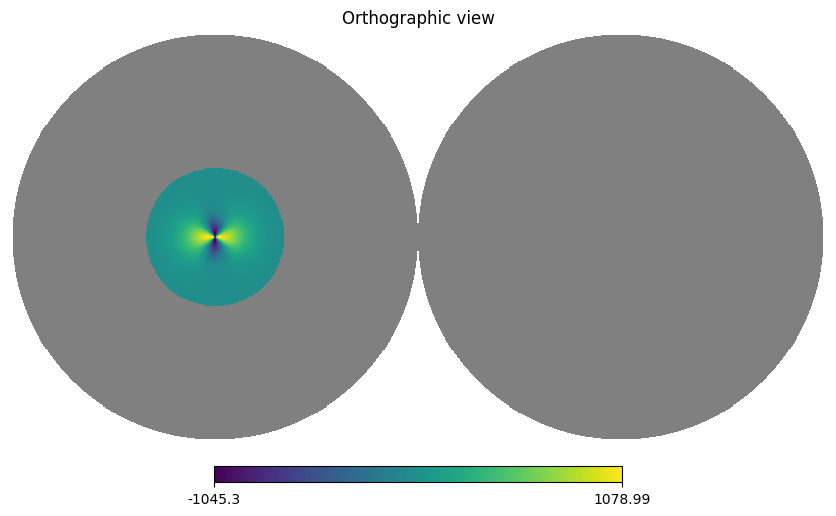

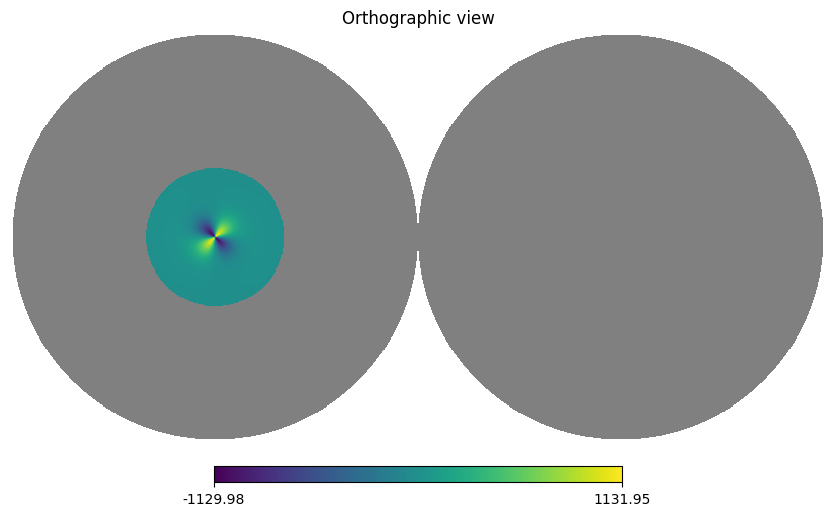

In [15]:
g2a_beam = g2a.BeamCut('spherical_cut.cut')
g2a_polar = g2a_beam.to_polar()
g2a_map = g2a_polar.to_map(nside)
hp.orthview(g2a_map.map[0], rot=(0,90))
hp.orthview(g2a_map.map[1], rot=(0,90))
hp.orthview(g2a_map.map[2], rot=(0,90))
